# Fashion Product Prediction

## Description
<p> Source : https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset </p> 

### Problem statement :
<p> Extract textual features of different products </p>
<p> Predict a products category by using textual features </p>

## Performance Metric

Metric(s):

    Log Loss
    Confusion Matrix

# Importing Libraries

In [181]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from scipy.sparse import hstack

from prettytable import PrettyTable
from collections import defaultdict
from tqdm import tqdm
import os
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Extraction

## Reading a random file - 1

In [2]:
#Reading a rondom file
json_df = pd.read_json('fashion-dataset/styles/59263.json')
json_df

,data,meta,notification
ageGroup,Adults-Women,NaN,NaN
articleAttributes,"{'Strap Material': 'Synthetic', 'Type': 'Hybri...",NaN,NaN
articleDisplayAttr,"{'id': 66, 'core': {'order': '0', 'display': '...",NaN,NaN
articleNumber,NB9796SM01,NaN,NaN
articleType,"{'id': 66, 'typeName': 'Watches', 'active': Tr...",NaN,NaN
baseColour,Silver,NaN,NaN
brandName,Titan,NaN,NaN
brandUserProfile,{'uidx': '28cf0b39.d898.4b6a.9541.77cb20672522...,NaN,NaN
catalogAddDate,1461843609,NaN,NaN
codEnabled,True,NaN,NaN


Every file has the above structure. There are many rows and 3 columns namely data, meta and notification.

Each file contains many different values for a product. For example id of product, year of product, price of product. 

We will use articleType, productDisplayName and productDescriptions.

### Extracting features

In [3]:
#extracting articleType
articleType = json_df.loc['articleType']['data']
print(articleType.keys())
print(articleType.values())

dict_keys(['id', 'typeName', 'active', 'socialSharingEnabled', 'isReturnable', 'isExchangeable', 'pickupEnabled', 'isTryAndBuyEnabled', 'isMyntsEnabled', 'serviceabilityDisclaimer'])
dict_values([66, 'Watches', True, True, True, True, True, True, True, {'title': '', 'desc': ''}])


The articleType has many keys inside it, we will use the typeName key.

In [4]:
#extracting productDisplayName
productDisplayName = json_df.loc['productDisplayName']['data']
print(productDisplayName)

Titan Women Silver Watch


In [5]:
#extracting productDescriptors from the random file
productDescriptors = json_df.loc['productDescriptors']['data']
print(productDescriptors.keys())
print(productDescriptors.values())

dict_keys(['materials_care_desc', 'size_fit_desc', 'description', 'style_note'])
dict_values([{'descriptorType': 'materials_care_desc', 'value': '<p>NA</p>'}, {'descriptorType': 'size_fit_desc', 'value': '<p>Case diameter: 25 mm<br />Dial shape: Round<br /></p>'}, {'descriptorType': 'description', 'value': '<p>Silver steel case with a fixed bezel for durability, style and comfort<br />Stainless steel strap with a butterfly clasp<br />White dial with silver hands<br />titan logo at the 6 hour mark<br />Screw to reset time<br />Solid case back for enhanced durability<br />Water resistance up to 30 meters, allowing you to use it even when showering <br />Warranty: 2 years</p>'}, {'descriptorType': 'style_note', 'value': '<p>This stylish watch from Titan, with classic, timeless styling is a must have for every well dressed woman. Built with the utmost precision and individuality, each watch has been designed and carefully tested to give you years of reliable service and contemporary style 

Here the productDescriptors is a dictionary with 4 keys.

Checking if other files contain the same fields or not

## Reading a random file - 2

In [0]:
#reading another random file
json_df = pd.read_json('fashion-dataset/styles/15970.json')

In [7]:
#extracting articleType
articleType = json_df.loc['articleType']['data']
print(articleType.keys())
print(articleType.values())

dict_keys(['id', 'typeName', 'active', 'socialSharingEnabled', 'isReturnable', 'isExchangeable', 'pickupEnabled', 'isTryAndBuyEnabled', 'isMyntsEnabled', 'serviceabilityDisclaimer'])
dict_values([85, 'Shirts', True, True, True, True, True, True, True, {'title': '', 'desc': ''}])


In [8]:
#extracting productDisplayName
productDisplayName = json_df.loc['productDisplayName']['data']
print(productDisplayName)

Turtle Check Men Navy Blue Shirt


In [9]:
productDescriptors = json_df.loc['productDescriptors']['data']
print(productDescriptors.keys())
print(productDescriptors.values())

dict_keys(['description'])
dict_values([{'descriptorType': 'description', 'value': '<p style="text-align: justify;"><strong>Composition</strong><br />Dark brown and indigo blue plaid check shirt with white accents, made of 100% cotton, has long sleeves with buttoned cuffs and a button on the elbow for rolling up the sleeve, denim spread collar, buttoned front placket, patch pocket on the upper left chest and a curved hemline<br /><br /><strong>Fitting</strong><br />Slim<br /><br /><strong>Wash care</strong><br />Machine wash cold at 30 degrees with like colours<br />Do not bleach <br />Wash and dry inside out<br />Hang to dry in shade<br />Medium iron<br /><br />The cleverly mitired pocket on the upper left chest and denim collar adds smooth styling to this dark brown and indigo blue plaid check shirt from turtle, while the cotton fabric keeps you feeling fresh and comfortable all day. Part of the proceeds from the sale of this product go towards the Save Turtle project in collaboratio

This file contains only 1 key in productDescriptors.

## Reading a random file - 3

In [0]:
#reading another random file
json_df = pd.read_json('fashion-dataset/styles/49168.json')

In [11]:
#extracting articleType
articleType = json_df.loc['articleType']['data']
print(articleType.keys())
print(articleType.values())

dict_keys(['id', 'typeName', 'active', 'socialSharingEnabled', 'isReturnable', 'isExchangeable', 'pickupEnabled', 'isTryAndBuyEnabled', 'isMyntsEnabled', 'serviceabilityDisclaimer'])
dict_values([85, 'Shirts', True, True, True, True, True, True, True, {'title': '', 'desc': ''}])


In [12]:
#extracting productDisplayName
productDisplayName = json_df.loc['productDisplayName']['data']
print(productDisplayName)

Spykar Men Navy Blue  Shirt


In [13]:
productDescriptors = json_df.loc['productDescriptors']['data']
print(productDescriptors.keys())
print(productDescriptors.values())

dict_keys([])
dict_values([])


This file does not contain any key in productDescriptors. It means that productDescriptors is empty.

#### Note :- All json files do not have discriptors with all 4 keys. Also some files do not contain any information in productDescriptors

## Extracting id, articleType, displayName, description and masterCategory from all files

In [35]:
path = './fashion-dataset/styles/'
files = os.listdir(path)                                          #getting list of all files in styles folder
#files = [i for i in os.listdir(path) if i.endswith("json")]      #use this if the folder contains files other than json format 

descriptors_df = pd.DataFrame()                                   #dataframe that will contarin extracted information
for filename in tqdm(files):
    file_path = path + filename
    json_df = pd.read_json(file_path)

    row = {}                                                                       #new row for each file that contains information
    id = json_df.loc['id']['data']
    row['id'] = id
    
    articleType_dict = json_df.loc['articleType']['data']                             #returns a dict    
    row['articleType'] = articleType_dict['typeName']
    
    row['productDisplayName'] = json_df.loc['productDisplayName']['data']

    productDescriptors_dict = json_df.loc['productDescriptors']['data']            #returns a dict
    if bool(productDescriptors_dict):                                              #empty dictionary evaluates to false
        row['description'] = productDescriptors_dict['description']['value']       #taking only discription value
    else:
        continue                                                                   #if dict is empty skip the file

    masterCategory_dict = json_df.loc['masterCategory']['data']
    row['masterCategory'] = masterCategory_dict['typeName']

    new_df = pd.DataFrame([row])                                                   #if we dont put row in [], it gives value error
    descriptors_df = descriptors_df.append(new_df, ignore_index = True)

100%|██████████| 44446/44446 [12:41<00:00, 32.37it/s]


In [36]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,Tshirts,"<p style=""text-align: justify;"">1. 100% cotton...",1845,Apparel,Inkfruit Mens Surfer T-shirt
1,Jeans,<p><strong>Composition</strong><br /> Blue jea...,23455,Apparel,Deni Yo Men Blue Washed Slim Fit Jeans
2,Earrings,<p>Silver earrings<br />Silver hoops with CZ s...,48721,Accessories,Lucera Women Silver Earrings
3,Casual Shoes,<p>Round toed shoes with central lace-ups<br /...,49381,Footwear,Vans Men Navy Blue Versa Casual Shoes
4,Kurtas,<p><strong>Composition</strong><br /> Mustard ...,25824,Apparel,Diva Women Printed Mustard Kurta


In [37]:
print('Total number of json files', len(files))
print('Total number of json files used in data extraction', descriptors_df.shape[0])

Total number of json files 44446
Total number of json files used in data extraction 44381


## Storing Extracted data to csv

Some descriptions contain **\r** which results in creating a new row in csv and imporper data storage. Removing \r from description

In [0]:
descriptors_df['description'] = descriptors_df['description'].apply(lambda row : row.replace('\r',''))

In [0]:
descriptors_df.to_csv('extracted_data.csv', index = False)

# Data Preprocessing

In [0]:
descriptors_df = pd.read_csv('extracted_data.csv')

In [50]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,Tshirts,"<p style=""text-align: justify;"">1. 100% cotton...",1845,Apparel,Inkfruit Mens Surfer T-shirt
1,Jeans,<p><strong>Composition</strong><br /> Blue jea...,23455,Apparel,Deni Yo Men Blue Washed Slim Fit Jeans
2,Earrings,<p>Silver earrings<br />Silver hoops with CZ s...,48721,Accessories,Lucera Women Silver Earrings
3,Casual Shoes,<p>Round toed shoes with central lace-ups<br /...,49381,Footwear,Vans Men Navy Blue Versa Casual Shoes
4,Kurtas,<p><strong>Composition</strong><br /> Mustard ...,25824,Apparel,Diva Women Printed Mustard Kurta


## Preprocessing articleType

In [51]:
#checking for null values
descriptors_df.articleType.isnull().any()

False

No null valuse found

Replacing space with _ and converting each articleType to lowercase

In [0]:
descriptors_df['articleType'] = descriptors_df['articleType'].apply(lambda row : row.replace(' ','_'))
descriptors_df['articleType'] = descriptors_df['articleType'].apply(lambda row : row.lower())

In [53]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,tshirts,"<p style=""text-align: justify;"">1. 100% cotton...",1845,Apparel,Inkfruit Mens Surfer T-shirt
1,jeans,<p><strong>Composition</strong><br /> Blue jea...,23455,Apparel,Deni Yo Men Blue Washed Slim Fit Jeans
2,earrings,<p>Silver earrings<br />Silver hoops with CZ s...,48721,Accessories,Lucera Women Silver Earrings
3,casual_shoes,<p>Round toed shoes with central lace-ups<br /...,49381,Footwear,Vans Men Navy Blue Versa Casual Shoes
4,kurtas,<p><strong>Composition</strong><br /> Mustard ...,25824,Apparel,Diva Women Printed Mustard Kurta


## Preprocessing displayName

In [55]:
#checking for null values
descriptors_df.productDisplayName.isnull().any()

True

Null values are present, removing null values

In [0]:
descriptors_df.dropna(subset = ['productDisplayName'], inplace = True)

In [0]:
descriptors_df['productDisplayName'] = descriptors_df['productDisplayName'].apply(lambda row : row.replace('-',''))
descriptors_df['productDisplayName'] = descriptors_df['productDisplayName'].apply(lambda row : row.lower())

In [79]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,tshirts,"<p style=""text-align: justify;"">1. 100% cotton...",1845,Apparel,inkfruit mens surfer tshirt
1,jeans,<p><strong>Composition</strong><br /> Blue jea...,23455,Apparel,deni yo men blue washed slim fit jeans
2,earrings,<p>Silver earrings<br />Silver hoops with CZ s...,48721,Accessories,lucera women silver earrings
3,casual_shoes,<p>Round toed shoes with central lace-ups<br /...,49381,Footwear,vans men navy blue versa casual shoes
4,kurtas,<p><strong>Composition</strong><br /> Mustard ...,25824,Apparel,diva women printed mustard kurta


## Preprocessing description

In [76]:
#checking for null values
descriptors_df.description.isnull().any()

False

No null values found, preprocessing the following things

1. Remove rows with description = '-'
2. Remove html tags
3. Remove words like Style Note, iuml, raquo, etc
4. Removing Special Characters
5. Stopword Removal

In [0]:
#https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
#function for reomving html tags
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

#https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
#function for removing multiple substrings in a string
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [81]:
#removing rows which contain only '-' in description
descriptors_df = descriptors_df[descriptors_df.description != '-']

preprocessed_descriptors = []
for text in tqdm(descriptors_df['description'].values):
    text = cleanhtml(text)
    
    d = { 'Style Note' : '', 'Composition' : '', 'nbsp' : '', 'iuml' : '', 'raquo' : '', 'iquest' : ''}
    text = replace_all(text, d)                                                                 #replace the above substrings with ''
    
    text = re.sub(r"\'s", " is", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)                                                   #remove special characters
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]    #gets a list of non stopwords
    text = ' '.join(text)                                                                       #join the words of above list using space
    preprocessed_descriptors.append(text.lower().strip())

100%|██████████| 43440/43440 [09:04<00:00, 79.85it/s]


In [0]:
data = pd.DataFrame()
data['id'] = descriptors_df['id'].values
data['articleType'] = descriptors_df['articleType'].values
data['productDisplayName'] = descriptors_df['productDisplayName'].values
data['preprocessed_description'] = preprocessed_descriptors
data['masterCategory'] = descriptors_df['masterCategory'].values

In [83]:
data.head()

,id,articleType,productDisplayName,preprocessed_description,masterCategory
0,1845,tshirts,inkfruit mens surfer tshirt,1 100 cottonthe entire front side shirt covere...,Apparel
1,23455,jeans,deni yo men blue washed slim fit jeans,blue jeans washed distressed look made 100 cot...,Apparel
2,48721,earrings,lucera women silver earrings,silver earringssilver hoops cz stone insets ou...,Accessories
3,49381,casual_shoes,vans men navy blue versa casual shoes,round toed shoes central lace ups padded inner...,Footwear
4,25824,kurtas,diva women printed mustard kurta,mustard printed kurta made 100 cotton fabric t...,Apparel


## Storing preprocessed data into csv

Due to preprocessing some of the descriptions have become empty. This results in NaN values in csv. 

In [90]:
data[data.preprocessed_description == ''].head()

,id,articleType,productDisplayName,preprocessed_description,masterCategory
51,40652,kurtas,span women mustard kurta,,Apparel
142,45034,watches,maxima men black dial watch,,Accessories
529,40639,kurtas,span women rust kurta,,Apparel
536,40629,kurtas,span women olive green kurta,,Apparel
600,27819,belts,bulchee men padded chino brown belt,,Accessories


Lests see what was the extracted description at these ids

In [95]:
ids = data[data.preprocessed_description == ''].head().id.values                        #taking the above ids
descriptors_df.loc[descriptors_df['id'].isin(ids)]

,articleType,description,id,masterCategory,productDisplayName
54,kurtas,<p>Style Note</p>,40652,Apparel,span women mustard kurta
146,watches,<p>Style Note</p>,45034,Accessories,maxima men black dial watch
545,kurtas,<p>Style Note</p>,40639,Apparel,span women rust kurta
552,kurtas,<p>Style Note</p>,40629,Apparel,span women olive green kurta
616,belts,<p>Style Note</p>,27819,Accessories,bulchee men padded chino brown belt


As extracted dataset contain only Style Note in its description, the preprocessed dataset has nothing in its description.

Removing rows with no description

In [0]:
data = data[data.preprocessed_description != '']

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43316 entries, 0 to 43439
Data columns (total 5 columns):
id                          43316 non-null int64
articleType                 43316 non-null object
productDisplayName          43316 non-null object
preprocessed_description    43316 non-null object
masterCategory              43316 non-null object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [0]:
data.to_csv('preprocessed_data.csv', index = False)

# Data Analysis

In [0]:
data = pd.read_csv('preprocessed_data.csv')

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43316 entries, 0 to 43315
Data columns (total 5 columns):
id                          43316 non-null int64
articleType                 43316 non-null object
productDisplayName          43316 non-null object
preprocessed_description    43316 non-null object
masterCategory              43316 non-null object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [101]:
print('Total number of data points are', data.shape[0])

Total number of data points are 43316


## Distribution of class labels 

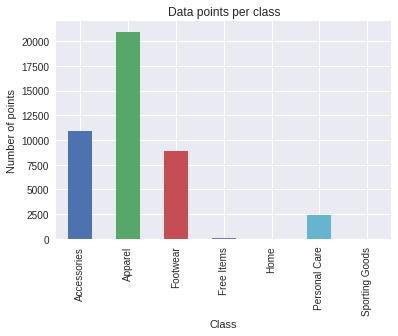

Number of data points in class 1 : 20955 ( 48.377 %)
Number of data points in class 0 : 10940 ( 25.256 %)
Number of data points in class 2 : 8902 ( 20.551 %)
Number of data points in class 5 : 2396 ( 5.531 %)
Number of data points in class 3 : 99 ( 0.229 %)
Number of data points in class 6 : 23 ( 0.053 %)
Number of data points in class 4 : 1 ( 0.002 %)


In [102]:
value_counts = data['masterCategory'].value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/data.shape[0]*100), 3), '%)')

The data is highly imbalaced, with class 1 covering 48% of total datapoints whiles classes 3 and 6 have only 0.229% and 0.053% of points. There is only one point for class 4 i.e. 0.002% of whole dataset.

As we have only one data point in 'Home' Class we remove that class

In [0]:
data = data[data.masterCategory != 'Home']

### Convering Categorical output into numerical output

In [104]:
le = LabelEncoder()

masterCategoryEncoded = le.fit_transform(data['masterCategory'])
data['masterCategoryEncoded'] = masterCategoryEncoded
data.head()

,id,articleType,productDisplayName,preprocessed_description,masterCategory,masterCategoryEncoded
0,1845,tshirts,inkfruit mens surfer tshirt,1 100 cottonthe entire front side shirt covere...,Apparel,1
1,23455,jeans,deni yo men blue washed slim fit jeans,blue jeans washed distressed look made 100 cot...,Apparel,1
2,48721,earrings,lucera women silver earrings,silver earringssilver hoops cz stone insets ou...,Accessories,0
3,49381,casual_shoes,vans men navy blue versa casual shoes,round toed shoes central lace ups padded inner...,Footwear,2
4,25824,kurtas,diva women printed mustard kurta,mustard printed kurta made 100 cotton fabric t...,Apparel,1


## Analysis on articleType

In [113]:
#different articles and their number of occurances
data['articleType'].value_counts()

tshirts                      6950
shirts                       3188
casual_shoes                 2683
watches                      2329
sports_shoes                 2017
kurtas                       1753
handbags                     1745
tops                         1704
heels                        1305
sunglasses                   1070
wallets                       922
flip_flops                    872
sandals                       863
briefs                        844
belts                         786
backpacks                     709
socks                         664
perfume_and_body_mist         608
formal_shoes                  605
jeans                         597
shorts                        533
trousers                      519
flats                         491
bra                           473
dresses                       449
sarees                        422
earrings                      417
deodorant                     347
nail_polish                   328
lipstick      

In [112]:
print('Total unique values in articleType are', len(data['articleType'].unique()))

Total unique values in articleType are 142


### Top articleType for each class

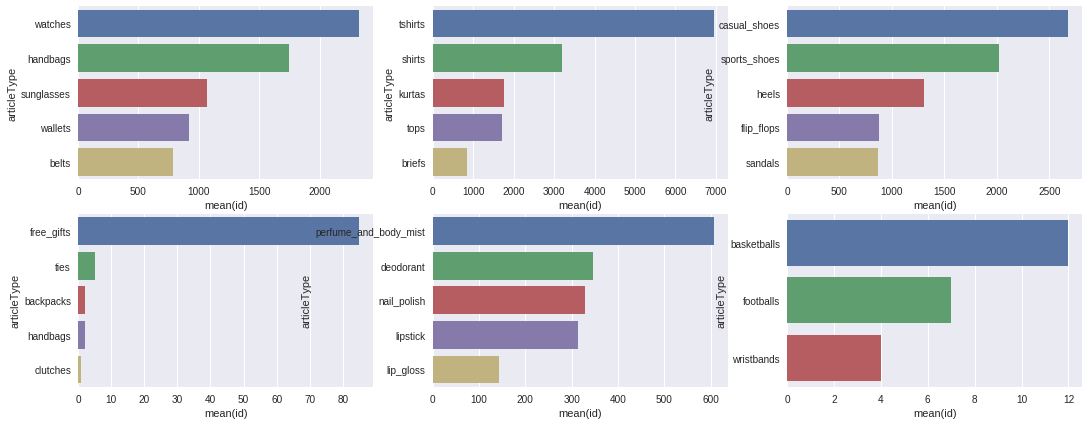

In [116]:
fix, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 7))

for i in range(2):
    for j in range(3):
        feature_counts = data[data['masterCategoryEncoded'] == i*3+j].groupby('articleType')['id'].count().reset_index()         #selecting a master category and grouping by articleType and counting values, 'id' is provided so that count values becomes a column
        sorted_feature_counts = feature_counts.sort_values('id', ascending = False)[0:5]
        sns.barplot(x = 'id', y = 'articleType', data = sorted_feature_counts, ax=axs[i][j])

Top articleType for each class are very different, hence this feature can be very usefull in classification.

## Analysis on displayName

### Top words for each class

In [0]:
#creating a dictionary which will contain a word as key and its frequency as value for a single class

#takes a dataframe which will contain rows of a particular class
def dictionary_for_class(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row['productDisplayName'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
dict_list = []                                             #a dictionary which will contain 6 dictionarys for each class

for i in range(0,6):
    df = data[data['masterCategoryEncoded'] == i]
    dict_list.append(dictionary_for_class(df))

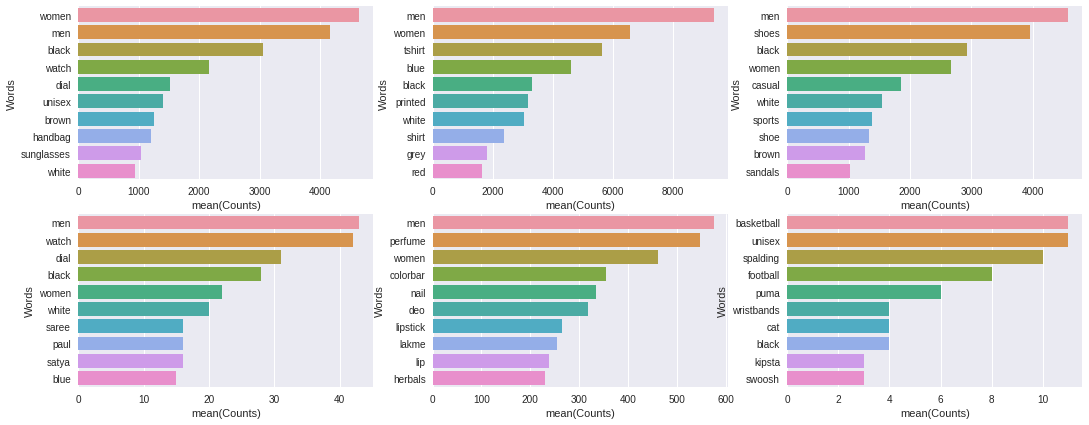

In [119]:
fix, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 7))

for i in range(2):
    for j in range(3):
        temp = pd.DataFrame(list(dict_list[(i*3+j)].items()), columns = ['Words', 'Counts'])
        sorted_words = temp.sort_values('Counts', ascending = False)[:10]
        sns.barplot(x = "Counts", y = "Words", data = sorted_words, ax=axs[i][j])

Top words for each categories have some common words like, men, women, black. white, etc. Hence this feature wont be much usefull in classification

## Analysis on discription

### Top words for each class

In [0]:
#creating a dictionary which will contain a word as key and its frequency as value for a single class

#takes a dataframe which will contain rows of a particular class
def dictionary_for_class(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row['preprocessed_description'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
dict_list = []                                             #a dictionary which will contain 6 dictionarys for each class

for i in range(0,6):
    df = data[data['masterCategoryEncoded'] == i]
    dict_list.append(dictionary_for_class(df))

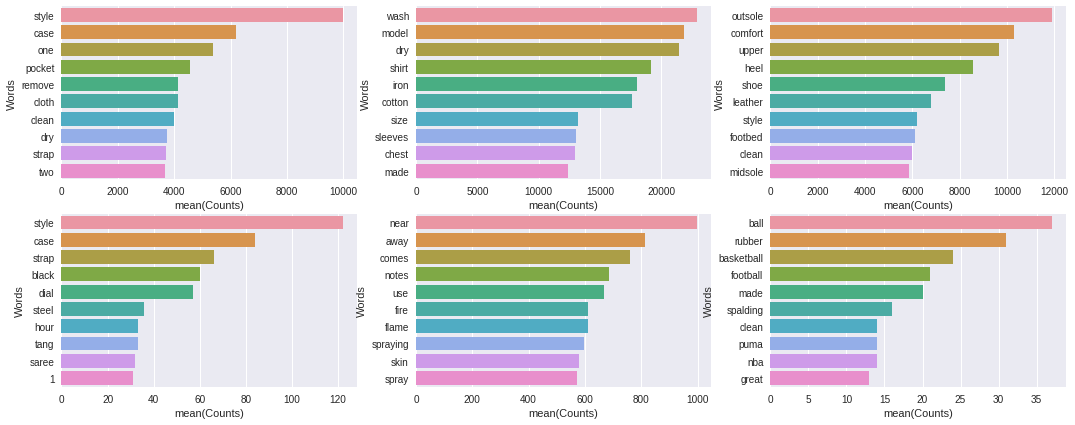

In [122]:
fix, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 7))

for i in range(2):
    for j in range(3):
        temp = pd.DataFrame(list(dict_list[(i*3+j)].items()), columns = ['Words', 'Counts'])
        sorted_words = temp.sort_values('Counts', ascending = False)[:10]
        sns.barplot(x = "Counts", y = "Words", data = sorted_words, ax=axs[i][j])

Top words are each class are very different except for class 0 and 3 i.e Accessories and Free Items. Maybe many of the  Free Items are Accessories.

As top words for each class are different we can easily classify the data points. However there are very few data points for Free Items and Sporting Goods classes, which can be a problem.

# Creating train and test dataset

## Splitting the dataset

In [143]:
#creating input and output parts
X = data.drop(['id', 'masterCategory', 'masterCategoryEncoded'], axis = 1)
Y = data['masterCategoryEncoded']

#splitting the data into train/test
X_tr, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 0)

print("Shape of tr data, cv data and test data is : ", X_tr.shape, X_test.shape)

Shape of tr data, cv data and test data is :  (34652, 3) (8663, 3)


In [144]:
X_tr.head()

,articleType,productDisplayName,preprocessed_description
33623,dresses,doodle girls printed pink dress,pink cream black printed dress made 100 cotton...
40591,tshirts,lotto women cathy pink tshirt,pink v neck shirt short sleeves gold embroider...
7049,nightdress,red rose women blue nightdress,light blue knee length night dress orange trim...
42746,sports_shoes,nike women white sports shoes,superior grip ultra lightweight package city c...
2714,sarees,fnf red & blue evening wear sari,blue red mustard coloured printed georgette sari


### Distribution of class labels for train and test data.

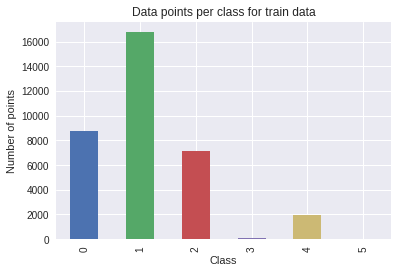

Number of data points in class 1 : 16764 ( 48.378 %)
Number of data points in class 0 : 8752 ( 25.257 %)
Number of data points in class 2 : 7122 ( 20.553 %)
Number of data points in class 4 : 1917 ( 5.532 %)
Number of data points in class 3 : 79 ( 0.228 %)
Number of data points in class 5 : 18 ( 0.052 %)
--------------------------------------------------------------------------------


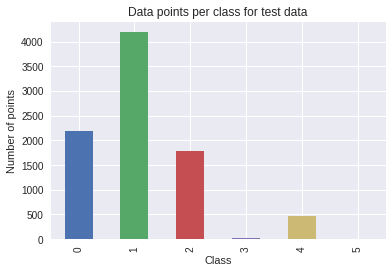

Number of data points in class 1 : 4191 ( 48.378 %)
Number of data points in class 0 : 2188 ( 25.257 %)
Number of data points in class 2 : 1780 ( 20.547 %)
Number of data points in class 4 : 479 ( 5.529 %)
Number of data points in class 3 : 20 ( 0.231 %)
Number of data points in class 5 : 5 ( 0.058 %)


In [145]:
value_counts = Y_tr.value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class for train data')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/X_tr.shape[0]*100), 3), '%)')
    
   
print('-'*80)
value_counts = Y_test.value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class for test data')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/X_test.shape[0]*100), 3), '%)')

## Encoding Features

### One Hot encoding of articleType

In [146]:
vectorizer = CountVectorizer(lowercase = False, binary = True)
articleType_tr = vectorizer.fit_transform(X_tr['articleType'].values)
articleType_test = vectorizer.transform(X_test['articleType'].values)

print("Shape of matrix after one hot encoding ",articleType_tr.shape)
print("Shape of matrix after one hot encoding ",articleType_test.shape)

Shape of matrix after one hot encoding  (34652, 140)
Shape of matrix after one hot encoding  (8663, 140)


### Bag of words encoding of product displayName

In [147]:
vectorizer = CountVectorizer(min_df = 10)
displayName_tr = vectorizer.fit_transform(X_tr['productDisplayName'])
displayName_test = vectorizer.transform(X_test['productDisplayName'])

print("Shape of matrix after bow encoding ",displayName_tr.shape)
print("Shape of matrix after bow encoding ",displayName_test.shape)

Shape of matrix after bow encoding  (34652, 1186)
Shape of matrix after bow encoding  (8663, 1186)


### Bag of words encoding of product description

In [148]:
vectorizer = CountVectorizer(min_df = 10)
description_tr = vectorizer.fit_transform(X_tr['preprocessed_description'])
description_test = vectorizer.transform(X_test['preprocessed_description'])

print("Shape of matrix after bow encoding ",description_tr.shape)
print("Shape of matrix after bow encoding ",description_test.shape)

Shape of matrix after bow encoding  (34652, 7174)
Shape of matrix after bow encoding  (8663, 7174)


### Stacking the above features

In [0]:
Xtr = hstack((articleType_tr, displayName_tr, description_tr)).tocsr()
Xtest = hstack((articleType_test, displayName_test, description_test)).tocsr()

## TSNE visualization of data points

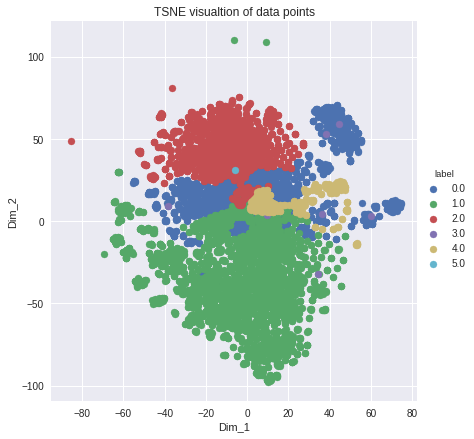

In [150]:
x = Xtr.toarray()[:5000]
y = Y_tr[:5000]
model = TSNE(n_components = 2, perplexity = 50, random_state = 0)
tsne_data = model.fit_transform(x)
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title("TSNE visualtion of data points")
plt.show()

The graph shows that data is quite seperable, only at some points there is overlap between the classes

# Machine Learning Modelling

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis = 1))).T)
    B = (C/C.sum(axis = 0))

    labels = [0, 1, 2, 3, 4, 5]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize = (15,7))
    sns.heatmap(C, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize = (15,7))
    sns.heatmap(B, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize = (15,7))
    sns.heatmap(A, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Random Model

Log loss on Test Data using Random Model 2.076862579593794
-------------------- Confusion matrix --------------------


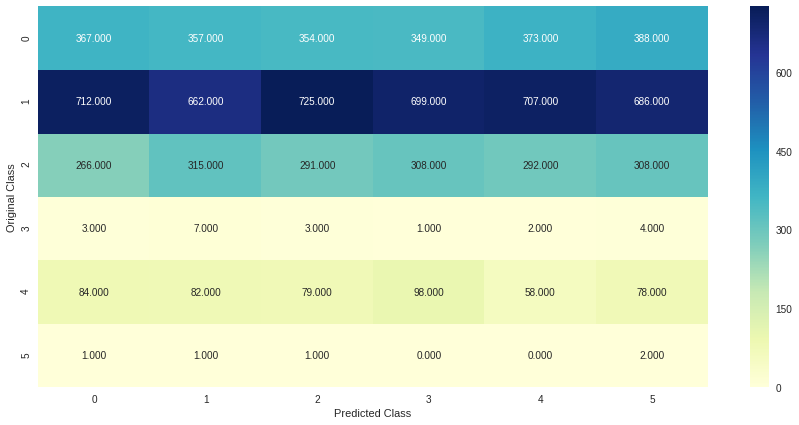

-------------------- Precision matrix (Columm Sum=1) --------------------


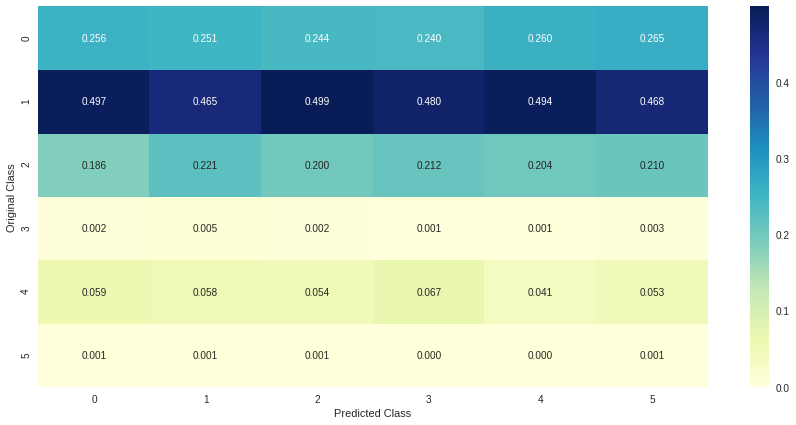

-------------------- Recall matrix (Row sum=1) --------------------


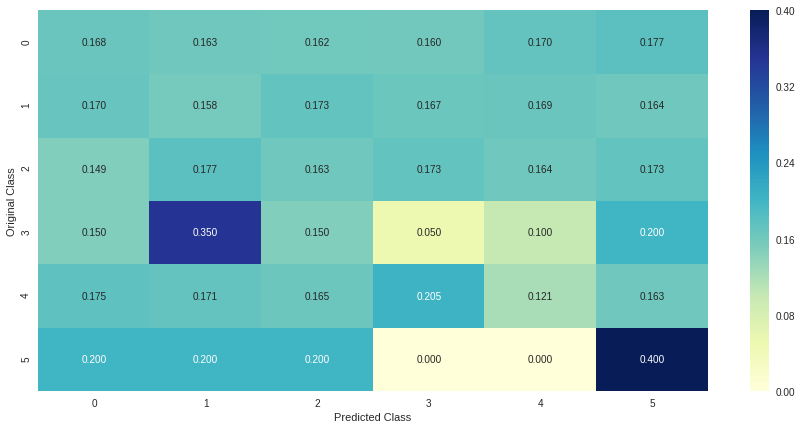

In [153]:
# we need to generate 6 numbers and the sum of numbers should be 1
# one solution is to genarate 6 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = Xtest.shape[0]

#Test set
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len, 6))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 6)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(Y_test, test_predicted_y, eps = 1e-15))

predicted_y = np.argmax(test_predicted_y, axis = 1)
plot_confusion_matrix(Y_test, predicted_y)

## Logistic Regression model

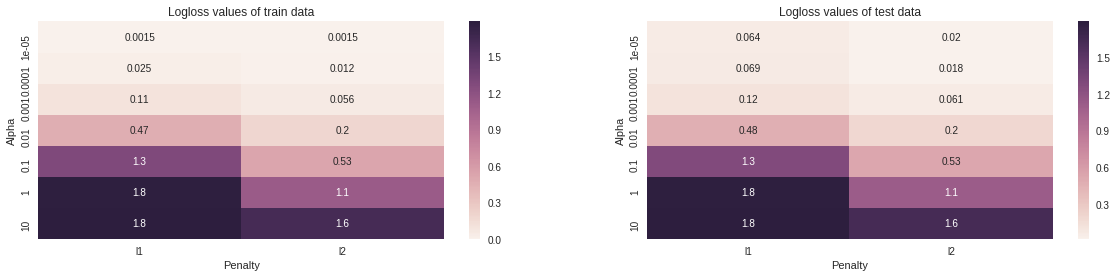

In [173]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']

parameters = {'alpha' : alpha, 'penalty' : penalty}
clf = SGDClassifier(loss = 'log')
model = GridSearchCV(clf, param_grid = parameters, scoring = 'neg_log_loss')
model.fit(Xtr, Y_tr)

results = pd.DataFrame(model.cv_results_)
params = results['params']
logloss_tr_array = -results['mean_train_score']
logloss_cv_array = -results['mean_test_score']
  

#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
scores_tr = -model.cv_results_['mean_train_score'].reshape(len(alpha),len(penalty))
sns.heatmap(scores_tr, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('Logloss values of train data')

plt.subplot(1, 2, 2)
scores_test = -model.cv_results_['mean_test_score'].reshape(len(alpha),len(penalty))
sns.heatmap(scores_test, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('Logloss values of test data')
plt.show()

Values of best parameters are {'alpha': 0.0001, 'penalty': 'l2'} , train logloss is 0.011534356524320449 and test logloss is 0.017692126523187256
-------------------- Confusion matrix --------------------


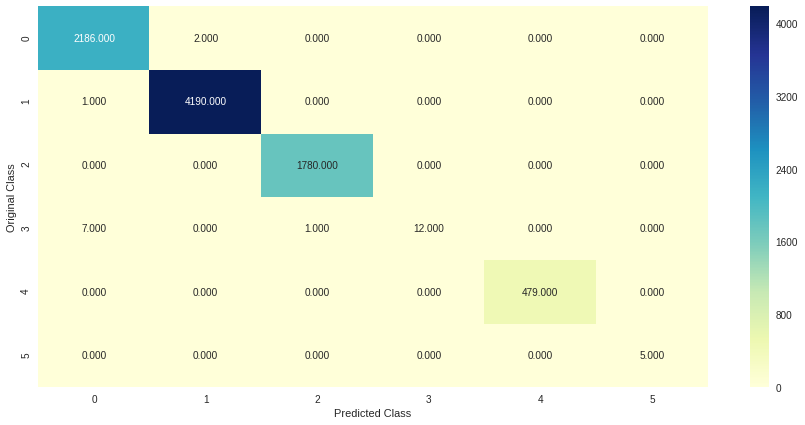

-------------------- Precision matrix (Columm Sum=1) --------------------


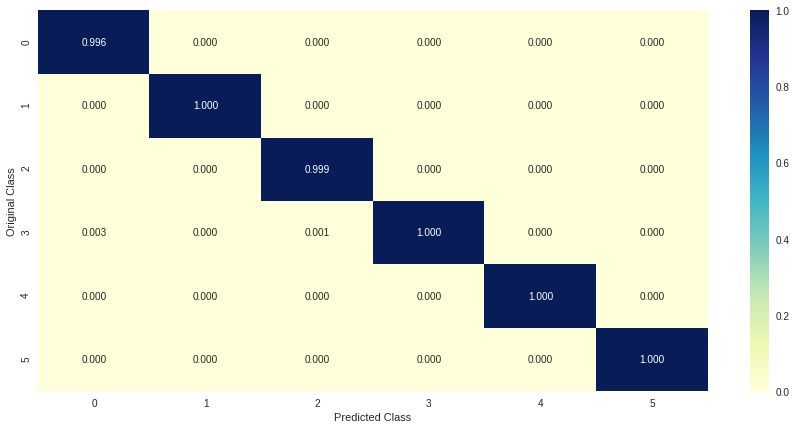

-------------------- Recall matrix (Row sum=1) --------------------


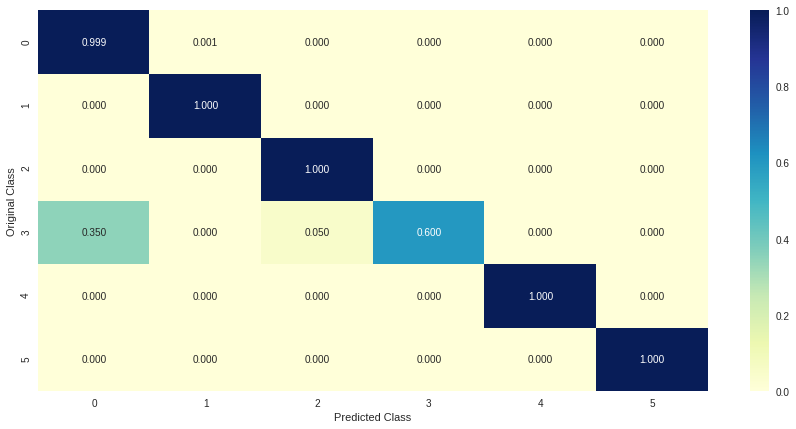

In [174]:
params_lr = model.best_params_
logloss_tr_lr = -model.cv_results_['mean_train_score'][model.best_index_]
logloss_test_lr = -model.cv_results_['mean_test_score'][model.best_index_]
print("Values of best parameters are",params_lr, ", train logloss is", logloss_tr_lr, "and test logloss is", logloss_test_lr)

plot_confusion_matrix(Y_test, model.predict(Xtest))

As said before that Free Items(Class 3) are similar to Accesorries(Class0), we can see in the confusion matrix and recall matrix of test set, that the points belonging to class 3 are getting predicted as class 0 class 2. 

## Random Forest Model

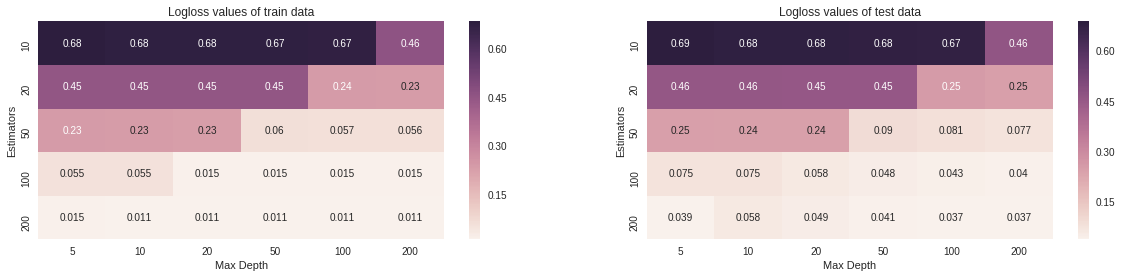

In [179]:
max_depth = [5, 10, 20, 50, 100, 200]
n_estimators = [10, 20, 50, 100, 200]

parameters = {'max_depth' : max_depth, 'n_estimators' : n_estimators}
clf = RandomForestClassifier()
model = GridSearchCV(clf, param_grid = parameters, scoring = 'neg_log_loss')
model.fit(Xtr, Y_tr)

results = pd.DataFrame(model.cv_results_)
params = results['params']
logloss_tr_array = -results['mean_train_score']
logloss_cv_array = -results['mean_test_score']


#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
scores_tr = -model.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(scores_tr, annot = True, xticklabels = max_depth, yticklabels = n_estimators)
plt.xlabel('Max Depth')
plt.ylabel('Estimators')
plt.title('Logloss values of train data')

plt.subplot(1, 2, 2)
scores_test = -model.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(scores_test, annot = True, xticklabels = max_depth, yticklabels = n_estimators)
plt.xlabel('Max Depth')
plt.ylabel('Estimators')
plt.title('Logloss values of test data')
plt.show()

Values of best parameters are {'max_depth': 200, 'n_estimators': 200} , train logloss is 0.010560799580791624 and test logloss is 0.03654766879420128
-------------------- Confusion matrix --------------------


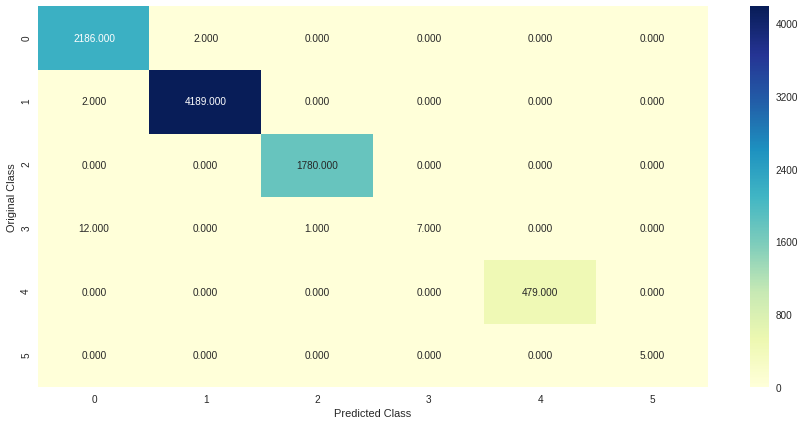

-------------------- Precision matrix (Columm Sum=1) --------------------


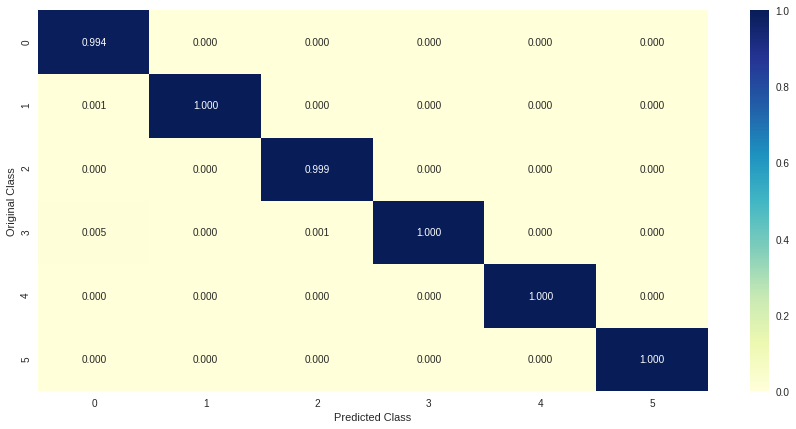

-------------------- Recall matrix (Row sum=1) --------------------


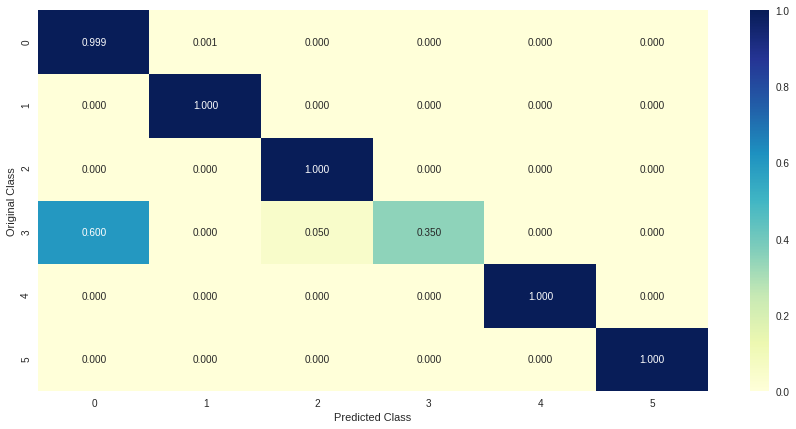

In [180]:
params_rf = model.best_params_
logloss_tr_rf = -model.cv_results_['mean_train_score'][model.best_index_]
logloss_test_rf = -model.cv_results_['mean_test_score'][model.best_index_]
print("Values of best parameters are",params_rf, ", train logloss is", logloss_tr_rf, "and test logloss is", logloss_test_rf)

plot_confusion_matrix(Y_test, model.predict(Xtest))

## XGBoost Model

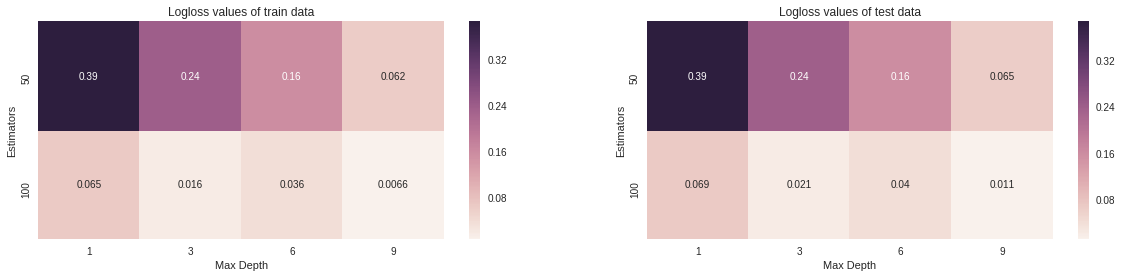

In [184]:
max_depth = [1, 3, 6, 9]
n_estimators = [50, 100]

parameters = {'max_depth' : max_depth, 'n_estimators' : n_estimators}
clf = XGBClassifier()
model = GridSearchCV(clf, param_grid = parameters, scoring = 'neg_log_loss')
model.fit(Xtr, Y_tr)

results = pd.DataFrame(model.cv_results_)
params = results['params']
logloss_tr_array = -results['mean_train_score']
logloss_cv_array = -results['mean_test_score']


#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
scores_tr = -model.cv_results_['mean_train_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(scores_tr, annot = True, xticklabels = max_depth, yticklabels = n_estimators)
plt.xlabel('Max Depth')
plt.ylabel('Estimators')
plt.title('Logloss values of train data')

plt.subplot(1, 2, 2)
scores_test = -model.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
sns.heatmap(scores_test, annot = True, xticklabels = max_depth, yticklabels = n_estimators)
plt.xlabel('Max Depth')
plt.ylabel('Estimators')
plt.title('Logloss values of test data')
plt.show()

Values of best parameters are {'max_depth': 9, 'n_estimators': 100} , train logloss is 0.006638756136553983 and test logloss is 0.011402879991920871
-------------------- Confusion matrix --------------------


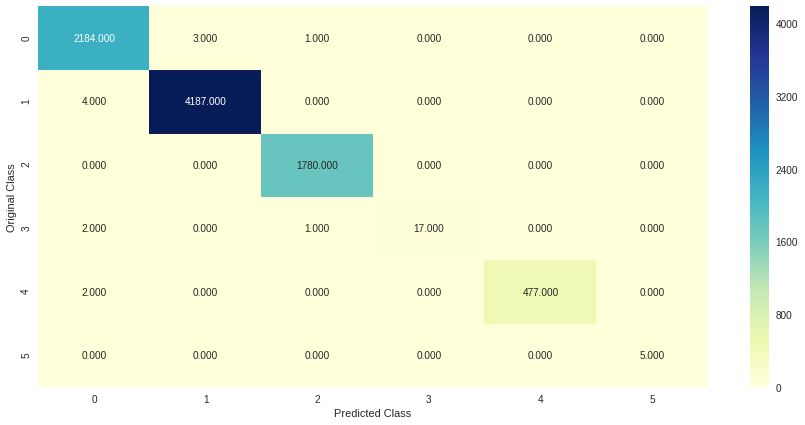

-------------------- Precision matrix (Columm Sum=1) --------------------


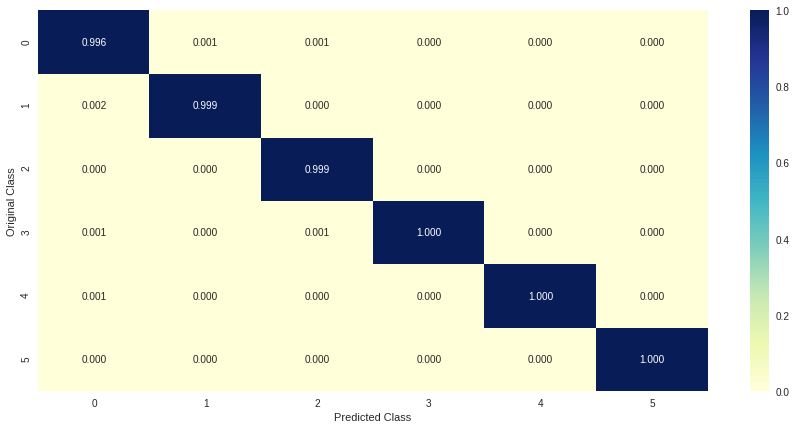

-------------------- Recall matrix (Row sum=1) --------------------


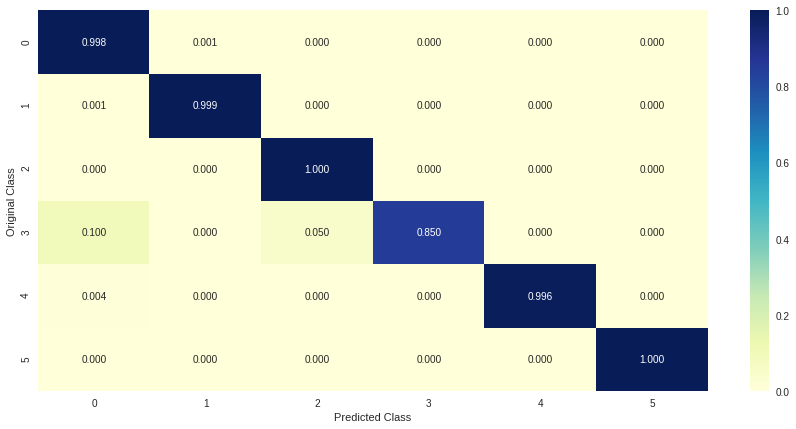

In [185]:
params_xgb = model.best_params_
logloss_tr_xgb = -model.cv_results_['mean_train_score'][model.best_index_]
logloss_test_xgb = -model.cv_results_['mean_test_score'][model.best_index_]
print("Values of best parameters are",params_xgb, ", train logloss is", logloss_tr_xgb, "and test logloss is", logloss_test_xgb)

plot_confusion_matrix(Y_test, model.predict(Xtest))

# Step by Step Procedure

1. Reading json files and extracting product data from json files
2. Preprocessing the extracted data, such as removal of html tags, removal of stopwords, etc from description and display name of products
3. Analysis on different features describing how much different values they can take for each class
4. Featuring data using one hot encoding and bag of words encoding
5. Modelling data using Logistic Regression, Random Forest and XGBoost

# Model Comparison

In [186]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["Model", "Best Parameters", "Train Logloss", "Test Logloss"]
t.add_row(["Logistic Regression", params_lr, logloss_tr_lr, logloss_test_lr])
t.add_row(["Random Forest", params_rf, logloss_tr_rf, logloss_test_rf])
t.add_row(["XGBoost", params_xgb, logloss_tr_xgb, logloss_test_xgb])
print(t)

+---------------------+-----------------------------------------+----------------------+----------------------+
|        Model        |             Best Parameters             |    Train Logloss     |     Test Logloss     |
+---------------------+-----------------------------------------+----------------------+----------------------+
| Logistic Regression |    {'alpha': 0.0001, 'penalty': 'l2'}   | 0.011534356524320449 | 0.017692126523187256 |
|    Random Forest    | {'max_depth': 200, 'n_estimators': 200} | 0.010560799580791624 | 0.03654766879420128  |
|       XGBoost       |  {'max_depth': 9, 'n_estimators': 100}  | 0.006638756136553983 | 0.011402879991920871 |
+---------------------+-----------------------------------------+----------------------+----------------------+
